In [2]:
from dataclasses import dataclass, field
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Tuple
from pathlib import Path
from failure_recognition_signal_processing.parse_kgt_data import create_machine_object, combine_multi_machine_data
from failure_recognition_signal_processing.assess_kgt_data import assess_test_results_in_envelope, classify_using_envelope, calculate_envelope, plot_sensor_envelope, split_training_data_by_label

from failure_recognition_signal_processing.parse_kgt_data import Machine

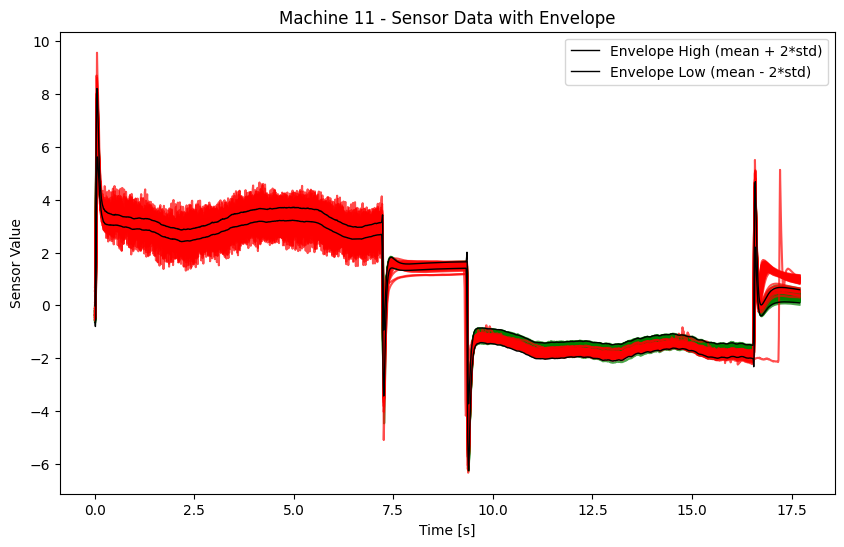

In [3]:
# Example usage:

label_file = Path("labels\\11.xlsx")
machine_file = Path("machine_data\\11.csv")
time_range = (0, 17.70)  # Example time range from 0 to 120 seconds
beta_envelope = 2

machine = create_machine_object(machine_file, label_file, time_range, dict())

sensor_sx = machine.get_sensor_data_by_name("s5").dataframe

sensor_sx_data_label_1 = sensor_sx.loc[:, machine.labels == True]
sensor_sx_data_label_0 = sensor_sx.loc[:, machine.labels == False]

envelope = calculate_envelope(sensor_sx_data_label_0, beta_envelope)

plot_sensor_envelope(envelope, sensor_sx_data_label_0, sensor_sx_data_label_1, beta_envelope, "Machine 11")


# Multiple machines (cross validation)

In [4]:
time_range = (0.2, 17.70)  # Example time range from 0 to 120 seconds
sensor_name = "s5"
machine_cnt = 15
beta_envelope = 2
envelope_min_total_violation = 20 # min data points outside the evelope to be labelled as "1"
replacement_dates = {"7": 109, "11": 95, "12": 74, "14": 52} # maps machine number to first index after replacement

In [5]:
machine_list: List[Machine] = []
skipped_names = []

for i in range(1, machine_cnt):
    label_file = Path(f"labels\\{i}.xlsx")
    machine_file = Path(f"machine_data\\{i}.csv")    
    
    try:
        machine = create_machine_object(machine_file, label_file, time_range, replacement_dates)
    except Exception as e:
        skipped_names.append(str(i))
        continue
    else:
        machine_list.append(machine)

print(f"Skipping machines {skipped_names} (for nan values or missing .csv file)")

tmp = (set(replacement_dates.keys()) - set(skipped_names)) - set([m.machine_name for m in machine_list])
assert(len(tmp) == 0)

Skipping machines ['2', '9', '13'] (for nan values or missing .csv file)


Merging training data from 11 machines


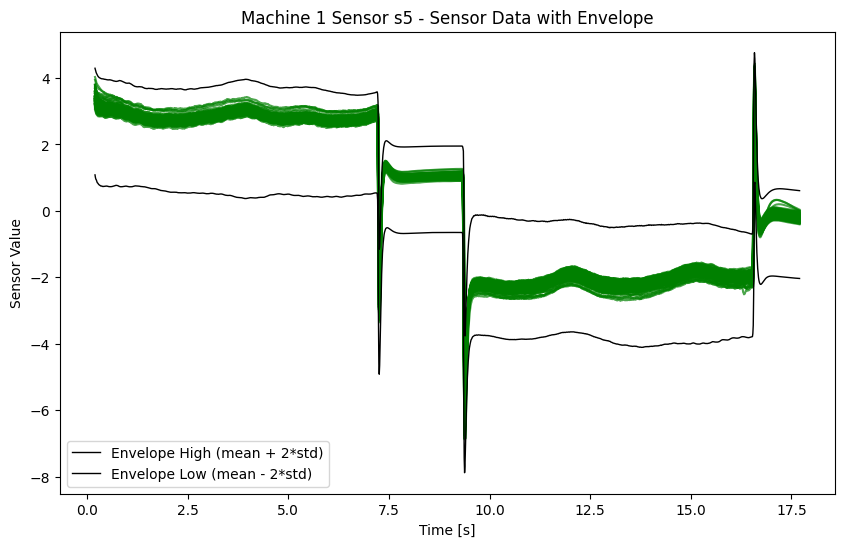

Merging training data from 11 machines


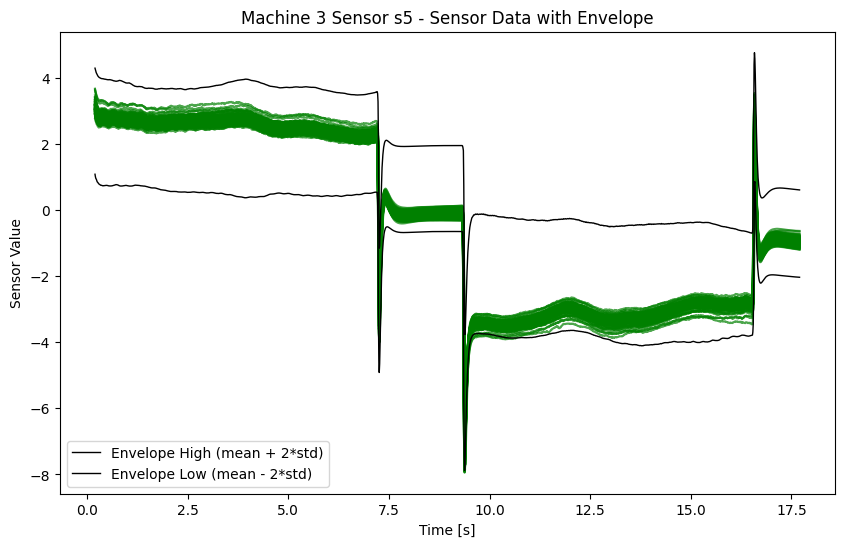

Merging training data from 11 machines


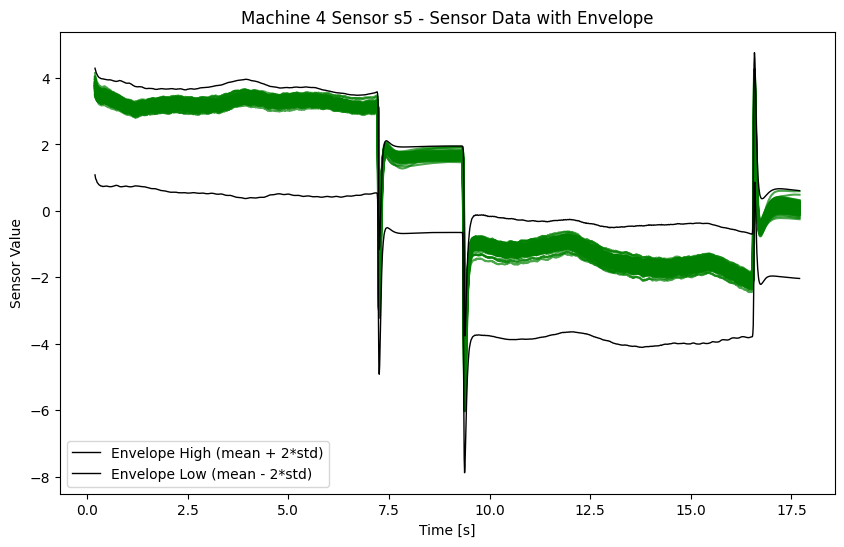

Merging training data from 11 machines


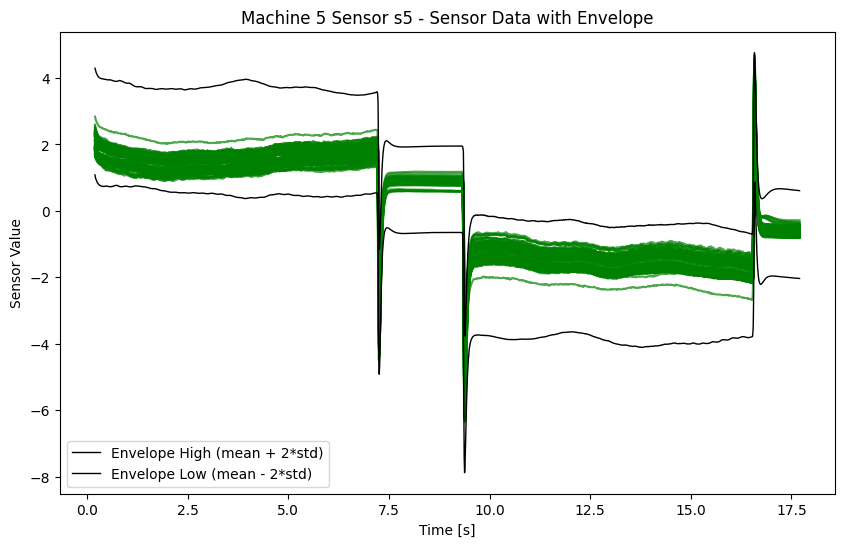

Merging training data from 11 machines


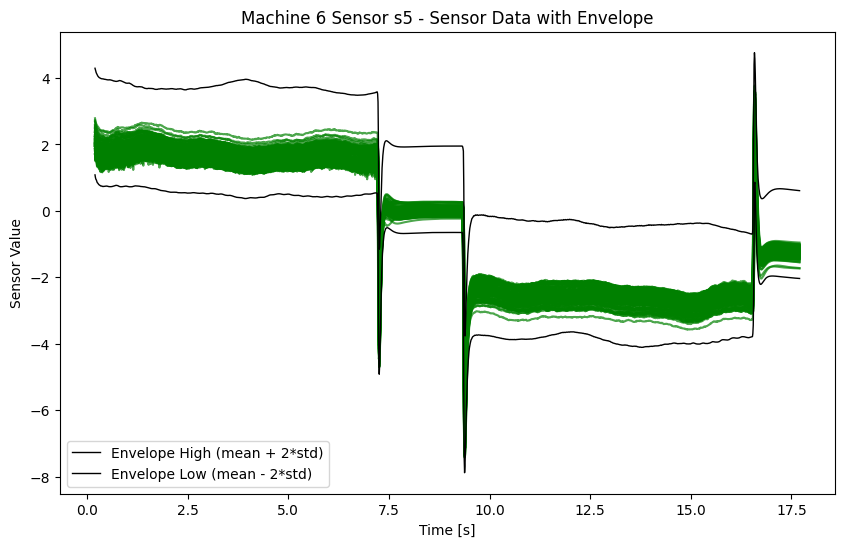

Merging training data from 11 machines


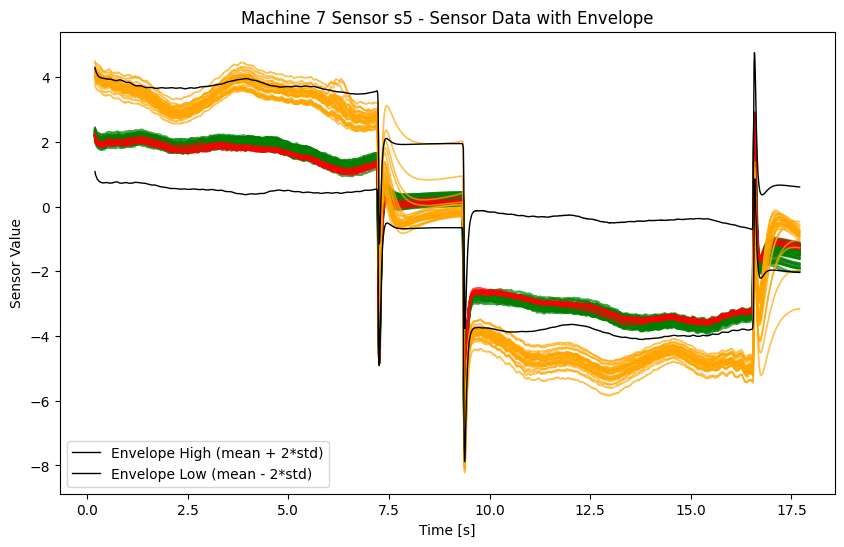

Merging training data from 11 machines


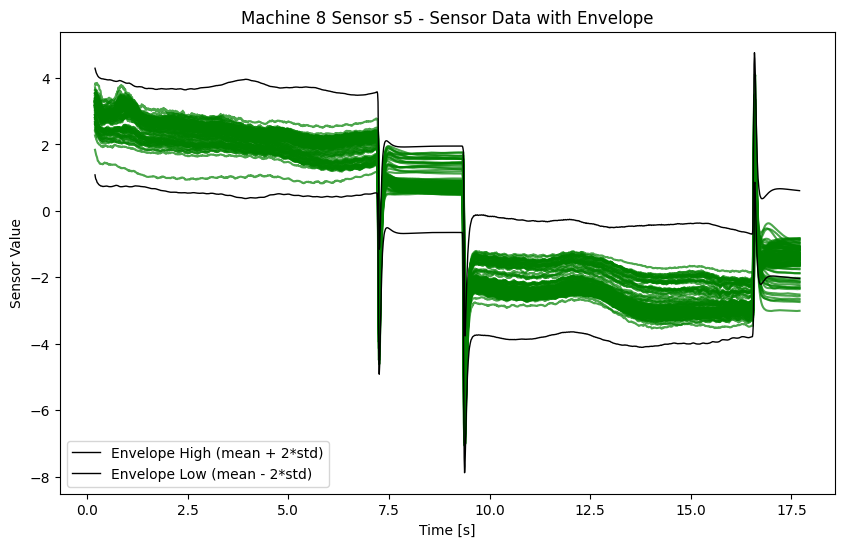

Merging training data from 11 machines


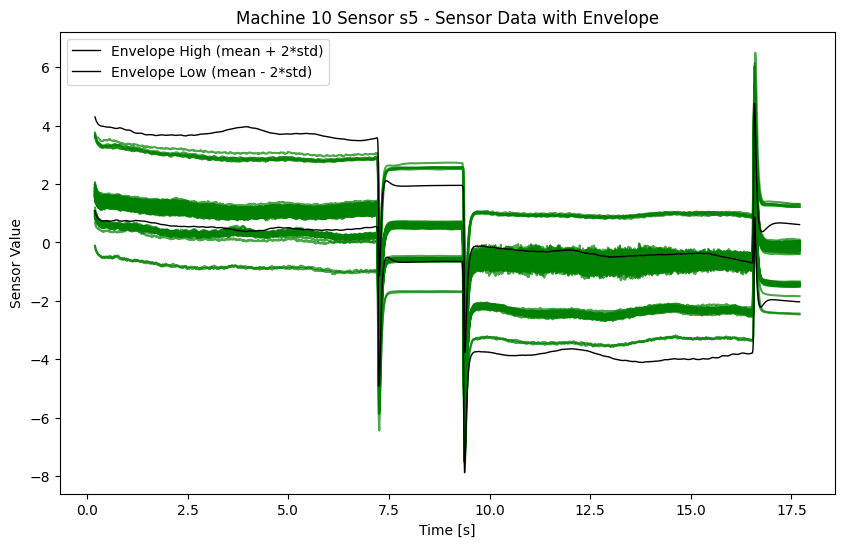

Merging training data from 11 machines


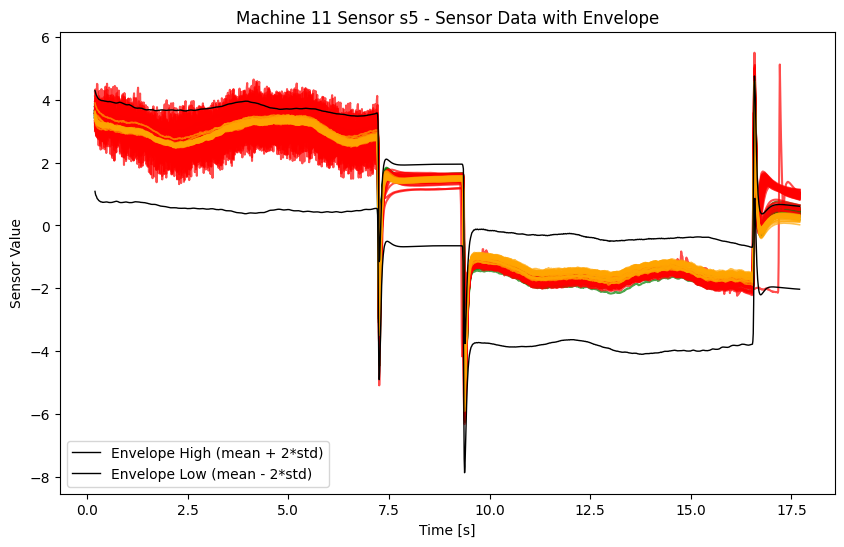

Merging training data from 11 machines


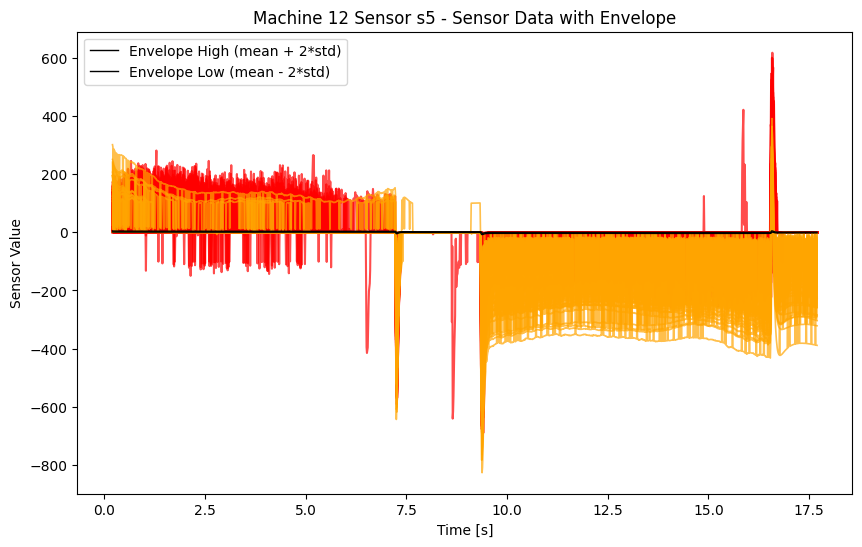

Merging training data from 11 machines


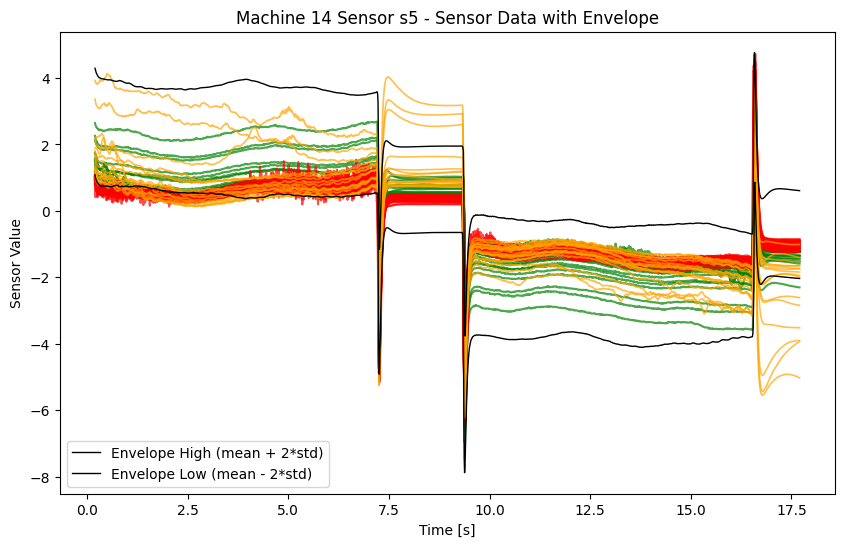

+----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+
|                |   Machine 1 |   Machine 3 |   Machine 4 |   Machine 5 |   Machine 6 |   Machine 7 |   Machine 8 |   Machine 10 |   Machine 11 |   Machine 12 |   Machine 14 |
+================+=============+=============+=============+=============+=============+=============+=============+==============+==============+==============+==============+
| FPR            |           0 |   0.0232558 |           0 |           0 |           0 |  0.00917431 |    0.137931 |     0.697183 |     0.494737 |            0 |     0.846154 |
+----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+
| F1             |             |             |             |             |             |  0          |             

In [6]:
from tabulate import tabulate

f1_scores = []
false_positive_rate = []
false_positive_rate_post_fix = []

# Perform cross validation
for _, test_machine in enumerate(machine_list):
    test_machine: Machine # test machine (i) against all other machines

    training_machines: List[Machine] = [x for j, x in enumerate(machine_list) if j != i]
    
    training_df_combined, training_labels_combined = combine_multi_machine_data(sensor_name, training_machines)

    training_data_0, training_data_1 = split_training_data_by_label(training_df_combined, training_labels_combined)

    # Create envelope from training data with label 0 (no defect)
    envelope = calculate_envelope(training_data_0, beta_envelope)

    test_sensor_df = test_machine.get_sensor_data_by_name(sensor_name).dataframe

    test_data_0, test_data_1 = split_training_data_by_label(test_sensor_df, test_machine.labels)

    if test_machine.labels_post_fix is not None:
        test_sensor_df_post_fix = test_machine.get_sensor_data_by_name(sensor_name, post_fix=True).dataframe
        test_data_0_post_fix, test_data_1_post_fix = split_training_data_by_label(test_sensor_df_post_fix, test_machine.labels_post_fix)
        plot_sensor_envelope(envelope, test_data_0, test_data_1, beta_envelope, f"Machine {test_machine.machine_name} Sensor {sensor_name}", test_data_0_post_fix)
    else:
        plot_sensor_envelope(envelope, test_data_0, test_data_1, beta_envelope, f"Machine {test_machine.machine_name} Sensor {sensor_name}")

    predictions = classify_using_envelope(test_sensor_df, envelope, min_total_violation=envelope_min_total_violation)    
    fpr, f1 = assess_test_results_in_envelope(test_machine.machine_name, test_machine.labels, predictions)
    
    false_positive_rate.append(fpr)
    f1_scores.append(f1)

    if test_machine.labels_post_fix is not None:
        test_sensor_df_post_fix = test_machine.get_sensor_data_by_name(sensor_name, post_fix=True).dataframe
        predictions_post_fix = classify_using_envelope(test_sensor_df_post_fix, envelope, min_total_violation=envelope_min_total_violation)    
        fpr_post_fix, _ = assess_test_results_in_envelope(test_machine.machine_name, test_machine.labels_post_fix, predictions_post_fix)
        false_positive_rate_post_fix.append(fpr_post_fix)
    else:
        false_positive_rate_post_fix.append((test_machine.machine_name, None))

# Data for plotting
categories = [f"Machine {m.machine_name}" for m in machine_list]
data =[["FPR"] + [float(x[1]) if x[1] is not None else None for x in false_positive_rate],
       ["F1"] + [float(x[1]) if x[1] is not None else None for x in f1_scores],
       ["FPR (Post Fix)"] + [float(x[1]) if x[1] is not None else None for x in false_positive_rate_post_fix]]

print(tabulate(data, headers=categories, tablefmt='grid'))

         id      time     S001  S002  S003  S004  S005  S006  S007  S008  ...  \
0         1  3.674380  3.59587   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1         1  3.628130  3.53595   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2         1  3.583400  3.48626   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3         1  3.536800  3.44651   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         1  3.510780  3.43369   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...     ...       ...      ...   ...   ...   ...   ...   ...   ...   ...  ...   
213617  122 -0.119866      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
213618  122 -0.121273      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
213619  122 -0.122618      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
213620  122 -0.123915      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
213621  122 -0.126272      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

        S0113  S0114  S0115